# Chapter 42. Portfolio Value at Risk and Conditional Value at Risk

CVaR(Conditional Value at Risk) 는 현대적 risk management 의 가장 powerful 한 도구 중 하나이다. CVaR 은 "가장 최악의 p percent 의 날에 얼마나 많은 손실을 볼 것으로 예상되는가 ?" 라는 물음을 평가하고 답변한다. 이 것은 현재의 portfolio 가 risk tolerance level 을 충족하는지와 asset 들을 선정할 때에 다수의 portfolio 를 평가하는데 이용된다. 또한 portfolio optimization 에도 유용하다. 

Value at Risk (VaR) 은 portfolio risk management 의 key concept 이다. 서로 다른 가능도(likelihood) 수준에서 미래 손실이 어떨지  평가하기 위해 과거에 관측된 portfolio return 의 distribution 을 사용한다. 예제로서 이해해 보자.

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
import time

import matplotlib.pyplot as plt

## Simulated Data Example

np.random.normal 을 이용하여 10 개의 가상의 asset 의 return 을 simulate 한다.

#### NOTE

return 을 simulate 하기 위해 정규분포를 이용하는데, 실제 세계의 return 은 정규분포를 결코 따르지 않고 통상적으로 fat tail 을 포함한 이상한 행동을 보인다.

* numpy.random.normal(mu, std, size(tuple)) --> size : output shape

,Asset 0,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9
0,-0.017192,0.262956,-0.144613,-0.156917,0.256559,0.042812,-0.166633,0.070784,0.014677,0.104459
1,-0.054386,-0.110278,-0.003452,-0.005419,-0.130964,0.073586,0.007553,0.007835,0.004822,0.006158
2,0.038857,0.023531,-0.021586,0.148740,0.026579,-0.168384,-0.084832,-0.032183,-0.014224,0.049984
3,0.085679,-0.018248,0.128393,0.072574,0.078605,0.097901,0.037038,-0.117490,0.055490,0.077932
4,0.184177,-0.026638,-0.019165,-0.039889,-0.068544,-0.002857,0.096459,0.052912,-0.069140,0.067438


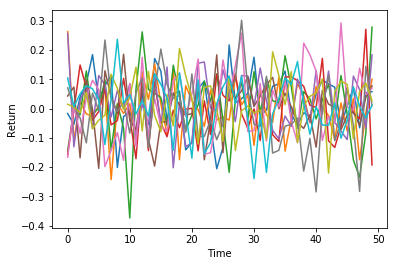

In [2]:
# mu = 0.01, std = 0.10, 1000 bars, 10 assets  --> asset 10 개의 mu 와 std 가 모두 같다고 가정
mu = 0.01
sigma = 0.10    
bars = 1000
num_assets = 10

returns = np.random.normal(mu, sigma, (bars, num_assets))      # (1000, 10)

# Fake asset names
names = ['Asset %s' %i  for i in range(num_assets)]

# Put in a pandas dataframe
returns = pd.DataFrame(returns, columns=names)

# Plot the last 50 bars
plt.plot(returns.head(50))
plt.xlabel('Time')
plt.ylabel('Return');

returns.head()

coverage $\alpha$ 에 있어서의  VaR(Value at Risk) 는  $p = 1 - \alpha$ 의 가능성으로 돈을 잃을 최대금액으로 정의된다. 달리 이야기 하면,  VaR 보다 더 잃을 날은 $100 \times p \%$ 일수 보다 많지 않다. VaR 을 평가하는 많은 방법이 있는데, 어느 것도 완벽하지는 않다. 실제로 VaR 을 너무 믿으면 안되고 오히려 다른 수준의 극단적 시나리오에서 얼마나 잃을 수 있는지 감을 잡는 용도로 사용되어야 하고, 이 정보를 risk management 책임자에게 제공해야 한다.

높은 $\alpha$ 에 대한 VaR 은 최악의 결과를 측정하는 수단이다. 예를 들어, 우리는 $\alpha = 0.999$ VaR 이 1/000 확률을 추적해서 crisis event 가 결과에 얼마나 영향을 줄까하는 것을 이해할 수 있다. 실제 분포는 분산되어 있고 tail 로 갈수록 점점 일관성이 떨어지므로 극단적 VaR 은 적당히 새겨서 이해해야 한다.

### Relationship to Confidence Intervals

신뢰구간은 VaR 과 매우 비슷하다. $\alpha$ 로 표시되는 구간을 이용하여 가능한 값의 집합 cover 하려하는 idea 는 VaR 이 가능한 손실의 집합을 cover 하려는 것과 비슷하다.

### Historical (Non-Parametric) VaR

우리는과거의 return 분포를 나타내는 역사적 VaR(historical VaR) 을 $p$ percentile 을 계산하는데 사용할 것이다. 

이 percentile 은 ,미래의 return 이 과거 return 에 근사하다고 가정할 때, 확률 $p$ 로 입을 것으로 합리적으로 예상되는 손실금액이다. 즉, 이 것은 완벽하지 않다. 다시 말하지만 이것은 완벽하지 않고, return 의 분포가 변화할 regime change 가 없다고 가정한다. 예를 들어, historical window 에 crisis event 가 포함되지 않았다면, VaR 평가는 실제보다 훨씬 낮게 나올 것이다.

coverage $\alpha$ 에 대한 역사적 VaR 을 계산하려면 단순히 가장 낮게 관측된 return 들의 $100 \times (1 - \alpha)$ percentile 을 취하여 총 투자금액을 곱하면 된다.

* 백분위수(Percentile. 百分位數)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다. 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다. 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다. 

* numpy.percentile(a, q) : a - input array, q - Percentile to compute, which must be between 0 and 100 inclusive, returns percentile (If q is a single percentile and axis=None, then the result is a scalar)

이제 10 개 asset 집합의 VaR 을 계산해 본다. 이를 위해 portfolio weights 를 필요로 한다. 최대한 단순화하여 시작하자.

In [3]:
weights = np.ones((10, 1))
# Normalize
weights = weights / np.sum(weights)      #[[ 0.1],[ 0.1],....[ 0.1]]

In [4]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)               # (1000, 10)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)      # (520, 1)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

$\alpha = 0.95$ 에 대한 VaR 을 계산한다.

In [5]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95)

-39589.719179099564

위 내용을 해석하면, 위의 sample portfolio 는 역사적으로 $5%$ 이상의 일수들이 이 것보다 더 극단적인 손실을 기록하지 않았다는 것, 혹은 개별 날자를 기준으로 이만큼 잃을 확률이 $5%$ 보다 적다는 것이다. 이러한 종류의 예상은 단순히 예측일 뿐이란 것을 명심한다.

## 정규 vs. 비모수 역사적 VaR (Normal vs. Non-Parametric Historical VaR)


### Normal Case

VaR 의 특수한 경우는 return 들이 역사적으로 비모수적 평가되지 않고 주어진 분포를 따른다고 가정하는 것이다. 이 경우 정규 VaR 이 우리 data 에 맞을 것인데, 왜냐하면 모든 return 들이 정규분포를 simulation 한 형식이기 때문이다. 우리는 특정값의 가능도 계산을 위한 normal curve 의 아래 지역을 합산해 주는 normal distribution Cumulative Distribution Function (CDF) 을 이용하여 정규분포 여부를 check 할 수 있다. 우리는 inverse CDF 혹은 PPF 를 사용할 것인데, 이 것은 주어진 가능도(likelihood) 에 대해 어떤 값이 그 가능도에 해당하는지 알려준다.

특히, Normal VaR 의 closed form formula 는 다음과 같다.

$$VaR_{\alpha}(x) = \mu - \sigma N^{-1}(\alpha)$$

* 위 식에서 $N^{-1}(\alpha)$ 는 scipy.norm.ppf(alpha) 이다.

* norm.ppf(q) : returns percentiles
* norm.pdf(x, loc=0, scale=1) : Probability density function

In [6]:
# Portfolio mean return is unchanged, but std has to be recomputed
# This is because independent variances sum, but std is sqrt of variance (sigma 는 개별 자산의 std 이므로 portfolio 의 std 와 차이)
portfolio_std = np.sqrt( np.power(sigma, 2) * num_assets ) / num_assets   # sigma = 0.10, num_assets = 10
print(portfolio_std)
print(norm.ppf(0.95))
print(mu - portfolio_std * norm.ppf(0.95))
# manually value at risk 계산 , mu = 0.01
(mu - portfolio_std * norm.ppf(0.95)) * value_invested       # value_invested = 1000000

0.0316227766017
1.64485362695
-0.0420148387876


-42014.838787555738

manually 계산한 VaR 와 percentile 을 이용한 VaR 이 random variance 오차범위내로 비슷하다. continuous norm case 를 visualize 하여 확인해 본다. VaR 이 absolue loss 대신 return 으로 표현되었음을 주목한다. absolue loss 값을 구하려면 투자금액으로 곱하면 된다.

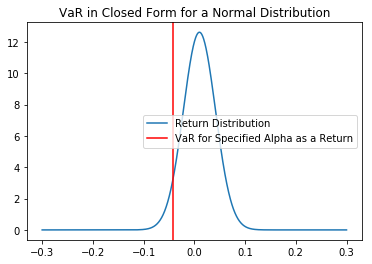

In [7]:
def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)

x = np.linspace(-3*sigma,3*sigma,1000)
y = norm.pdf(x, loc=mu, scale=portfolio_std)
plt.plot(x,y);
plt.axvline(value_at_risk_N(mu = 0.01, sigma = portfolio_std, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'])
plt.title('VaR in Closed Form for a Normal Distribution');

### Historical (Non-Parametric) Case

Historical VaR 은historical data 를 사용하여 확률밀도함수(discrete Probability Density Function) 혹은 histogram 을 그리고, point 들의 오직 $100 \times (1-\alpha)\%$ 만이 그 return 밑인 point 를 찾아낸다. 그것은 coverage  $\alpha$ 에 대한 VaR return 으로서의 return 을 반환한다.

Then finds the point at which only $100 \times (1-\alpha)\%$ of the points are below that return. It returns that return as the VaR return for coverage $\alpha$.

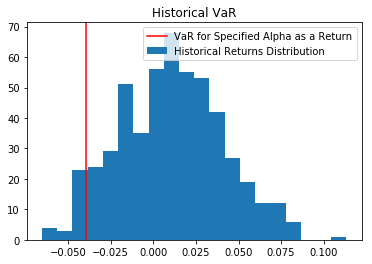

In [24]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)
portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
portfolio_VaR_return = portfolio_VaR / value_invested

# Need to express it as a return rather than absolute loss
plt.hist(portfolio_returns.values, bins=20, histtype='bar')
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');

### Underlying Distributions Are Not Always Normal

실제의 financial data 분포는 거의 normal 이 아니다. 이 때문에 우리가 historical VaR 을 선호하는 이유이다. 또한 Historical VaR 은 non-parametirc  하므로 특정 data set 의 distribution parameter 에 overfitting 될 염려가 없다.

#### Real Data Example

We'll show this on some real financial data.

In [64]:
# OEX components as of 3/31/16
# http://www.cboe.com/products/indexcomponents.aspx?DIR=OPIndexComp&FILE=snp100.doc
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CELG','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','CSOT','DHR','DOW','DUK','DD','EMC','EMR','EXC','XOM','FB','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET,','MSFT','MDZL','MON','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'RTN','SLB','SPG','SO','SBUX','TGT','TXN','BK','PCLN','TWX','FOXA','FOX','USB','UNP','UPS','UTX',
       'UNH','VZ','V','WMT','WBA','DIS','WFC']

In [54]:
def multi_returns(start, end, symbols):
    columns = []
    for symbol, market in symbols:
        columns.append(symbol)
        
    df = pd.DataFrame(columns=columns)
    
    for symbol, market in symbols:
        df[symbol] = pd.DataFrame(get_price_data({'q': symbol, 'i': "86400", 'x': market, 'p': "5Y" }))['Close'].loc[start : end]
    
    return df

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2016-04-04')     
df = multi_returns(start, end, [("MMM","NYSE"), ("T","NYSE"),("ABBV","NYSE"), ("ABT","NYSE"),("ACN","NYSE"), ("ALL","NYSE"),
                                            ("GOOGL","NASD"), ("GOOG","NASD"),("MO","NYSE"), ("AMZN","NASD"),("AXP","NYSE"), ("AIG","NYSE"),
                                            ("AAPL","NASD"), ("BAC","NYSE"),("BMY","NYSE"), ("BIIB","NASD"),("BLK","NYSE"), ("BA","NYSE"),
                                            ("CVS","NYSE"), ("COF","NYSE"),("CAT","NYSE"), ("CELG","NASD"),("CVX","NYSE"), ("CSCO","NASD"),
                                            ("C","NYSE"), ("KO","NYSE"),("CL","NYSE"), ("CMCSA","NASD"),("COP","NYSE"), ("DHR","NYSE"),
                                            ("DOW","NYSE"), ("DUK","NYSE"),("DD","NYSE"), ("EMC","NYSE"),("XOM","NYSE"), ("EXC","NYSE")])

Index(['MMM', 'T', 'ABBV', 'ABT', 'ACN', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AXP', 'AIG', 'AAPL', 'BAC', 'BMY', 'BIIB', 'BLK', 'BA', 'CVS', 'COF',
       'CAT', 'CELG', 'CVX', 'CSCO', 'C', 'KO', 'CL', 'CMCSA', 'COP', 'DHR',
       'DOW', 'DUK', 'DD', 'EMC', 'XOM', 'EXC'],
      dtype='object')

In [58]:
num_stocks = len(df.columns)
data = df

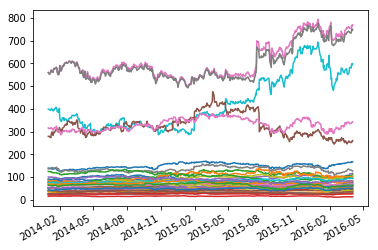

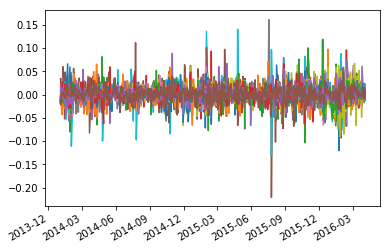

In [59]:
returns = data.pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

data.plot(legend=None);
returns.plot(legend=None); 

Now we need to generate some weights.

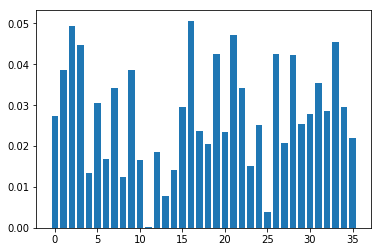

In [60]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights);

이제 $\alpha = 0.95$ 에 대한 VaR 을 계산해 보자. 이제부터 이 것을 $VaR_{\alpha=0.95}$ 로 표시하겠다.

In [65]:
value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520)

-17238.453812552758

Let's visualize this.

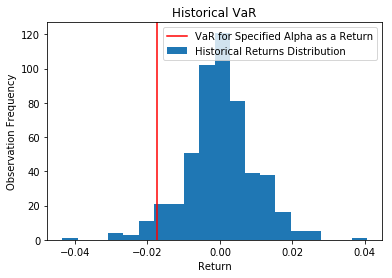

In [66]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

위의 분포는 육안으로도 non-normal 로 보인다. 그러나, statistical test 를 통하여 return 들이 non-normal 이라는 것을 확인하자. Jarque-Bera 를 사용하고, p-value cutoff 는 0.05 이다.

In [68]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print('The portfolio returns are likely normal.')
else:
    print('The portfolio returns are likely not normal.')

The portfolio returns are likely not normal.


확실히 return 들은 normal 하지 않다. 따라서 위에서 정규분포를 가정하고 VaR 계산을 한 것은 큰 실수이다.

## We Lied About 'Non-Parametric'

VaR 계산은 명백히 lookback window 를 사용한다. 이 parameter 가 없었으면 historical VaR 은 non-parametric (비모수적) 이었을 것이다.
이 lookback window 가 VaR 에 영향을 준다는 것을 생각하면, VaR 이 수렴할 정도의 충분히 긴 lookback window 를 선택하는 것이 중요하다. 실험을 통해 우리가 계산한 값이 수렴하는것 같은지 check 해 본다.

또한 예를 들어 500 일 window 에서 어떤 수렴이 되었다해도, 1000 일 전에 발생한 financial collapse 가 무시된 상태이므로 중요한 데이터가 누락된 상태임을 명심한다. 반대로, 모든 시점의 data 를 사용하는 것도 returns variance 가 non-stationary 이므로 무의미 하다. 기본적으로는 returns variance 가 시간 경과에 따라 변하므로, 예전에 한 측정은 더 이상 정확하지 않은 상태를 반영한 것일 것이다.

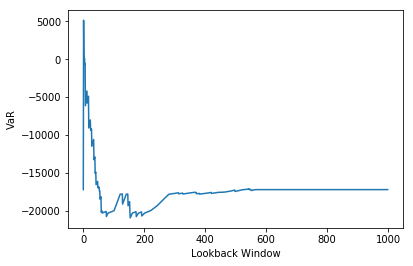

In [69]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days=i)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

VaR 이 400-600 lookback window 기간 범위에서 수렴하는 것을 볼수 있다. 따라서 우리가 설정한 520 일 parameter 는 무난한 것으로 보인다. 실제로 1000 이 더 많은 정보를 사용하므로 더 낳을 수 있지만, 더 많은 계산을 필요로 하고 여전히 stationarity 문제는 남아 있다.

이와 같은 분석을 통하여 VaR 이 의미 있는지 평가하는데 유용하다. 한가지 더 check 할 것은 시간 경과에 따른 portfolio return 의 stationarity 이다.

In [71]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print('Process is likely stationary.')
else:
    print('Process is likely non-stationary.')

Process is likely stationary.


## Conditional Value at Risk (CVaR)

CVaR 은 VaR 에 return 의 분포 모양을 계산에 포함 시키는 등 개선한 것이다. ES (Expected Shortfall) 라고도 불리는데 VaR 보다 큰 모든 가능한 손실예측과 과 그 가능도를 예측해 주기 때문이다.

### Expected Value

공정한 6 면 주사위가 있다고 하자. 각 숫자는 동등한 가능성을 갖는다. $\mathrm{E}(X)$ 로 모든 가능한 결과에서 발생 가능한 기대값을 표시한다.
이를 얻기 위해 각 event 의 가능성으로 각 event 를 곱하고 이를 모두 합한것을 probability weighted average 로 생각 한다. 주사위를 던져서 나올 수 있는 숫자는,

$$1/6 \times 1 + 1/6 \times 2 + 1/6 \times 3 + 1/6 \times 4 + 1/6 \times 5 + 1/6 \times 6 =  3.5$$

확률이 같지 않을 경우 더 복잡해지는데, 결과값이 연속적일 경우 closed form equation 의 적분을 이용해야 한다. CVaR 의 공식은 다음과 같다.

$$CVaR_{\alpha}(x) \approx \frac{1}{(1-\alpha)} \int_{f(x,y) \geq VaR_{\alpha}(x)} f(x,y)p(y)dy dx$$

In [72]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

Let's compute CVaR on our data and see how it compares with VaR.

In [73]:
cvar(value_invested, returns, weights, lookback_days=500)

-22579.60729589521

In [74]:
value_at_risk(value_invested, returns, weights, lookback_days=500)

-17432.496450390307

CVaR 값이 더 높은 이유는 분포의 모양에 관한 정보(분포의 moments 라고 함)를 더 capture 하기 때문이다. tail 에 mass 가 더 있을 수록, CVaR 은 그 것을 capture 한다. 일반적으로 VaR 보다 훨씬 우수한 metric 으로 간주되고 대부분 경우 VaR 보다 CVaR 을 사용해야 한다.

Let's visualize what it's capturing.

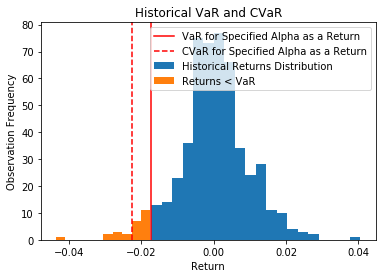

In [75]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

### Checking for Convergence Again

Finally, we'll check for convergence.

C:\Users\trimu\Miniconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


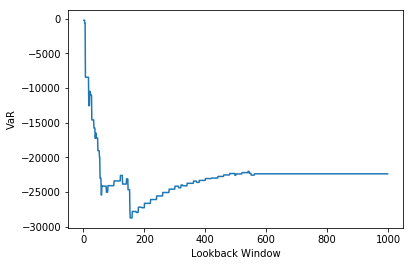

In [77]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');